# Diabetes Prediction: End-to-End Machine Learning Pipeline

This notebook presents a comprehensive workflow for diabetes prediction, including:

- Exploratory Data Analysis (EDA)
- Data Preprocessing & Feature Engineering
- Model Training (18+ models, including deep learning)
- Model Evaluation & Comparison
- Model Explainability (SHAP)
- Deployment Preparation

All steps are demonstrated using the Pima Indians Diabetes dataset.

## Part 1: Setup & Exploratory Data Analysis (EDA)

### Project Overview

This project demonstrates a robust machine learning pipeline for diabetes prediction using the Pima Indians Diabetes dataset. The workflow includes detailed EDA, data cleaning, feature engineering, model training with hyperparameter tuning, and model evaluation.

### Project Structure

1. **Setup & Imports**
2. **Data Loading & Initial Inspection**
3. **Exploratory Data Analysis**
   - Univariate, Bivariate, Multivariate Analysis
   - Statistical Tests
4. **Data Preprocessing**
   - Missing Value Treatment
   - Outlier Detection & Handling
   - Feature Transformations
5. **Feature Engineering**
   - Feature Creation & Selection (RFECV)
   - Dimensionality Reduction (PCA)
6. **Train/Test Split & Class Imbalance Handling (SMOTE)**
7. **Model Development (18+ algorithms)**
8. **Hyperparameter Tuning**
9. **Model Evaluation & Comparison**
10. **Feature Importance & Explainability (SHAP)**
11. **Model Saving & Deployment**
12. **Conclusion & Recommendations**

## 1. Setup & Imports

Import all required libraries for data analysis, visualization, preprocessing, modeling, and evaluation.

In [1]:
# Install required packages
!pip install -r requirements.txt

# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Statistical analysis
from scipy import stats
import statsmodels.api as sm

# Data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Metrics and evaluation
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report, 
                             roc_curve, precision_recall_curve, auc)
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC

# Model tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

# Class imbalance
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Model persistence
import joblib
import pickle

# Visualization for model explanation
import shap
from eli5 import show_weights, explain_prediction

# Set random seed for reproducibility
np.random.seed(42)

^C


ModuleNotFoundError: No module named 'seaborn'

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/102.5 MB ? eta -:--:--
    --------------------------------------- 1.3/102.5 MB 4.2 MB/s eta 0:00:25
    --------------------------------------- 2.4/102.5 MB 4.6 MB/s eta 0:00:22
   - -------------------------------------- 2.9/102.5 MB 4.3 MB/s eta 0:00:24
   - -------------------------------------- 3.7/102.5 MB 3.8 MB/s eta 0:00:26
   - -------------------------------------- 4.2/102.5 MB 3.4 MB/s eta 0:00:29
   - -------------------------------------- 4.5/102.5 MB 3.3 MB/s eta 0:00:30
   -- ------------------------------------- 5.2/102.5 MB 3.3 MB/s eta 0:00:30
   -- ------------------------------------- 6.3/102.5 MB 3.4 MB/s

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires keras>=3.2.0, but you have keras 2.10.0 which is incompatible.


## 2. Data Loading & Initial Inspection

Load the diabetes dataset and perform an initial exploration to understand its structure and identify potential issues.

In [ ]:
# Load the dataset
df = pd.read_csv('diabetes.csv')

# Display the first few rows
print("First 5 rows of the dataset:")
display(df.head())

# Dataset dimensions
print(f"Dataset shape: {df.shape}")

# Column information
print("\nColumn information:")
df.info()

In [ ]:
# Statistical summary
print("Statistical summary:")
display(df.describe())

# Check for missing values
print("\nMissing values in each column:")
display(df.isnull().sum())

# First check the actual column names in the dataframe
print("\nActual column names in the dataframe:")
print(df.columns.tolist())

# Check for zeros in medical variables (which likely represent missing values)
# Use the correct case and format of column names based on your actual dataframe
# This assumes column names might be lowercase or have different formatting
medical_cols = []
possible_columns = {
    'Glucose': ['glucose', 'Glucose', 'GLUCOSE'],
    'BloodPressure': ['bloodpressure', 'BloodPressure', 'blood_pressure', 'Blood Pressure', 'bp'],
    'SkinThickness': ['skinthickness', 'SkinThickness', 'skin_thickness', 'Skin Thickness'],
    'Insulin': ['insulin', 'Insulin', 'INSULIN'],
    'BMI': ['bmi', 'BMI', 'body_mass_index', 'Body Mass Index']
}

# Find the actual column names that exist in the dataframe
for standard_name, variations in possible_columns.items():
    found = False
    for variant in variations:
        if variant in df.columns:
            medical_cols.append(variant)
            found = True
            break
    if not found:
        print(f"Warning: Could not find a column matching '{standard_name}'")

print("\nZero values in medical columns (potential missing data):")
for col in medical_cols:
    zeros = (df[col] == 0).sum()
    print(f"{col}: {zeros} zeros ({zeros/len(df):.2%} of data)")

In [ ]:
# Using the correct target column name from your dataset
target_column = 'diabetes'  # This is the correct column name

# Check class distribution
class_counts = df[target_column].value_counts()
print("Class distribution:")
display(class_counts)

# Visualize class imbalance
plt.figure(figsize=(8, 6))
sns.countplot(x=target_column, data=df, palette='viridis')
plt.title('Class Distribution (0: Non-diabetic, 1: Diabetic)')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-diabetic', 'Diabetic'])
plt.show()

# Calculate imbalance ratio
imbalance_ratio = class_counts[0] / class_counts[1]
print(f"Imbalance ratio (Majority:Minority): {imbalance_ratio:.2f}:1")

## 3. Exploratory Data Analysis (EDA)

A thorough understanding of the data is essential before building predictive models. This section covers univariate, bivariate, and multivariate analyses to identify patterns and relationships.

### 3.1 Univariate Analysis

Examine the distribution of each feature to understand its central tendency, spread, and shape.

In [ ]:
# KDE plots for numeric features only
import numpy as np

# Identify numeric columns (exclude the target)
num_cols = df.select_dtypes(include=[np.number]).columns.drop('diabetes')

plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols):
    ax = plt.subplot(3, 3, i+1)
    sns.kdeplot(data=df, x=col, fill=True, color='skyblue')
    ax.set_title(f'Distribution of {col}')
    ax.axvline(df[col].mean(), color='r', linestyle='--', label='Mean')
    ax.axvline(df[col].median(), color='g', linestyle='-.', label='Median')
    if i == 0:
        ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Feature Distributions (KDE)', y=0.98, fontsize=16)
plt.show()

In [ ]:
# Box plots
plt.figure(figsize=(16, 10))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Box Plots for Feature Distribution and Outliers', y=0.98, fontsize=16)
plt.show()

# Violin plots
plt.figure(figsize=(16, 10))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.violinplot(y=df[col])
    plt.title(f'Violin Plot of {col}')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Violin Plots for Feature Distribution Shape', y=0.98, fontsize=16)
plt.show()

### 3.2 Bivariate Analysis

Analyze relationships between features and the target variable to identify predictive patterns.

In [ ]:
# 1. Print column names to confirm the target column
print("Columns:", df.columns.tolist())

# 2. Dynamically pick your outcome column and feature list
outcome_col = df.columns[-1]                     # last column, adjust index if needed
features    = [c for c in df.columns if c!=outcome_col]

# 3. Box‑plots for each feature by outcome
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))
for i, col in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=outcome_col, y=col, data=df, palette='viridis')
    plt.title(f'{col} by {outcome_col}')
    plt.xlabel(f'{outcome_col} (0=No, 1=Yes)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Feature Distributions by Outcome', y=0.98, fontsize=16)
plt.show()

In [ ]:
# 1. Print column names to confirm your target
print("Columns:", df.columns.tolist())

# 2. Dynamically pick your outcome column and feature list
outcome_col = df.columns[-1]                     # last column—adjust index if needed
features    = [c for c in df.columns if c != outcome_col]

# 3. Violin‑plots for each feature by outcome
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))
for i, col in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.violinplot(x=outcome_col, y=col, data=df, palette='viridis')
    plt.title(f'{col} by {outcome_col}')
    plt.xlabel(f'{outcome_col} (0=No, 1=Yes)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Feature Distribution Shapes by Outcome', y=0.98, fontsize=16)
plt.show()

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Confirm your columns & set the outcome col
print("Columns:", df.columns.tolist())
outcome_col = 'diabetes'               # or: df.columns[-1]

# 2. Keep only numeric features (drop the label)
numeric_features = df.select_dtypes(include='number').columns.tolist()
numeric_features.remove(outcome_col)

# 3. Dynamic grid sizing
n = len(numeric_features)
n_cols = 3
n_rows = math.ceil(n / n_cols)

# 4. Plot KDEs with hue
plt.figure(figsize=(5 * n_cols, 4 * n_rows))
for i, col in enumerate(numeric_features):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    sns.kdeplot(
        data=df,
        x=col,
        hue=outcome_col,
        fill=True,
        palette='viridis',
        alpha=0.5,
        common_norm=False,
        ax=ax
    )
    ax.set_title(f'{col} by {outcome_col}')
    if i == 0:
        ax.legend(title=outcome_col, labels=['Non‑diabetic', 'Diabetic'])
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Feature Distributions by Outcome (KDE)', y=0.98, fontsize=16)
plt.show()

NameError: name 'df' is not defined

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Keep only numeric columns (drops 'gender', 'smoking_history', etc.)
numeric_df = df.select_dtypes(include='number')

# 2. Correlation matrix
plt.figure(figsize=(10, 8))
corr_mat = numeric_df.corr()
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

# 3. Correlation with target variable
target_col = 'diabetes'
corr_target = corr_mat[target_col].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
corr_target.drop(target_col).plot(kind='bar', color='skyblue')
plt.title(f'Correlation with {target_col}', fontsize=16)
plt.ylabel('Pearson correlation')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

NameError: name 'df' is not defined

### 3.3 Multivariate Analysis

Explore interactions among multiple variables and their relationship with the target.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Confirm available columns
print("Columns:", df.columns.tolist())

# 2. Define your target and select numeric features
target_col    = 'diabetes'
numeric_feats = df.select_dtypes(include='number').columns.tolist()
numeric_feats.remove(target_col)

# 3. Build your feature list for the pairplot
key_features = numeric_feats + [target_col]
print("Pairplot features:", key_features)

# 4. Plot pairwise relationships
sns.pairplot(
    df[key_features],
    hue=target_col,
    palette='viridis',
    diag_kind='kde'
)
plt.suptitle('Pairwise Relationships between Key Features', y=1.02, fontsize=16)
plt.show()

NameError: name 'df' is not defined

NameError: name 'df' is not defined

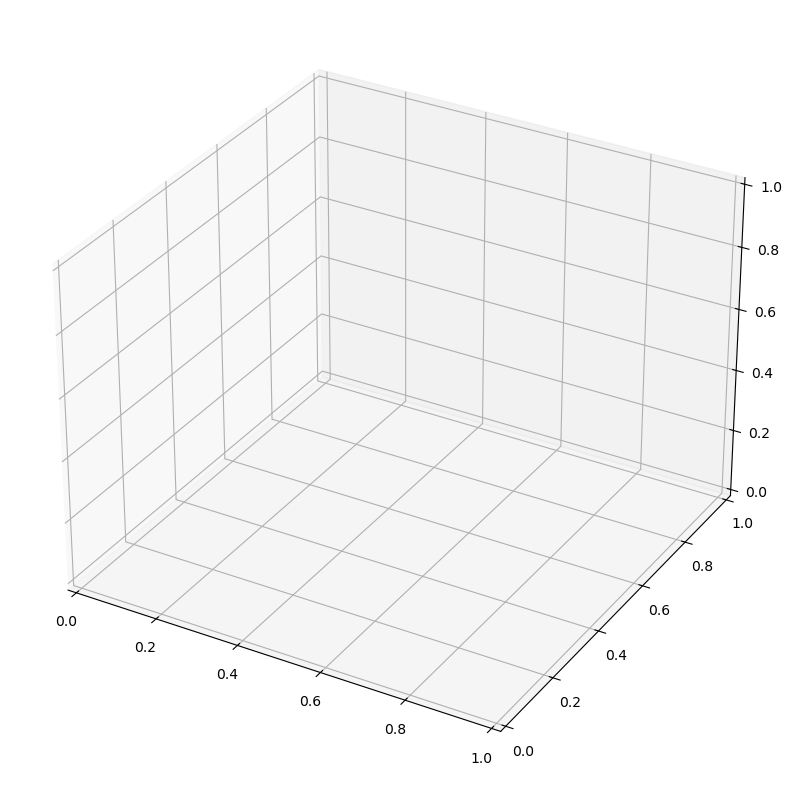

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

# real column names
x_col = 'blood_glucose_level'
y_col = 'bmi'
z_col = 'age'
target = 'diabetes'

fig = plt.figure(figsize=(12, 10))
ax  = fig.add_subplot(111, projection='3d')

xs     = df[x_col]
ys     = df[y_col]
zs     = df[z_col]
colors = ['blue' if o==0 else 'red' for o in df[target]]

ax.scatter(xs, ys, zs, c=colors, alpha=0.5)
ax.set_xlabel('Blood Glucose Level')
ax.set_ylabel('BMI')
ax.set_zlabel('Age')
ax.set_title('3D Relationship: Glucose, BMI, and Age', fontsize=16)

# custom legend
legend_elements = [
    Line2D([0],[0], marker='o', color='w', label='Non‑diabetic',
           markerfacecolor='blue', markersize=10),
    Line2D([0],[0], marker='o', color='w', label='Diabetic',
           markerfacecolor='red', markersize=10)
]
ax.legend(handles=legend_elements, title=target)

plt.show()

### 3.4 Statistical Tests

Perform statistical tests to quantify differences between diabetic and non-diabetic groups.

In [6]:
import numpy as np
import scipy.stats as stats

# 1. Identify numeric features and the target column
target       = 'diabetes'  
numeric_cols = df.select_dtypes(include='number').columns.tolist()
features     = [c for c in numeric_cols if c != target]

# 2. Run Welch’s t‑test for each feature
print("T‑tests comparing diabetic vs. non‑diabetic groups:\n")
for col in features:
    grp1 = df.loc[df[target] == 1, col]
    grp0 = df.loc[df[target] == 0, col]
    t_stat, p_val = stats.ttest_ind(grp1, grp0, equal_var=False, nan_policy='omit')
    
    print(f"{col}:")
    print(f"  Mean (Diabetic):     {grp1.mean():.2f}")
    print(f"  Mean (Non‑diabetic): {grp0.mean():.2f}")
    print(f"  T‑statistic:         {t_stat:.4f}")
    print(f"  P‑value:             {p_val:.4f}")
    print(f"  Significant (α=0.05): {'Yes' if p_val < 0.05 else 'No'}\n")

NameError: name 'df' is not defined

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif

# 1. Define your real target column
target_col = 'diabetes'

# 2. Keep only numeric features (drop the target)
X = df.select_dtypes(include='number').drop(columns=[target_col])
y = df[target_col]

# 3. Compute ANOVA F-values and p-values
f_values, p_values = f_classif(X, y)

# 4. Build and sort a results DataFrame
feature_scores = (
    pd.DataFrame({
        'Feature': X.columns,
        'F-value': f_values,
        'P-value': p_values
    })
    .sort_values('F-value', ascending=False)
)
print("ANOVA F-values and p-values for each feature:")
display(feature_scores)

# 5. Visualize top F-values
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Feature',
    y='F-value',
    data=feature_scores,
    palette='viridis'
)
plt.xticks(rotation=45)
plt.title('Feature Importance based on ANOVA F-values', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

## Part 2: Data Preprocessing & Feature Engineering

### Data Cleaning, Feature Engineering, and Preparation

This section covers missing value treatment, outlier handling, feature transformations, and engineering new features for improved model performance.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Set random seed for reproducibility
np.random.seed(42)

# Load data
df = pd.read_csv('diabetes.csv')
df.head()

### 4. Data Preprocessing

Handle missing values, outliers, and perform feature transformations to prepare the data for modeling.

#### 4.1 Missing Value Treatment

Replace physiologically impossible zero values in medical variables with NaN and visualize missing data patterns.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Confirm your columns
print("Columns:", df.columns.tolist())

# 2. Copy dataframe
df_clean = df.copy()

# 3. Replace zeros with NaN only for actual numeric measures
zero_cols = ['bmi', 'HbA1c_level', 'blood_glucose_level']
for col in zero_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].replace(0, np.nan)

# 4. Check missing counts
print("Missing values after zero replacement:")
display(df_clean.isnull().sum())

# 5. Visualize missing‑value pattern
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Value Patterns', fontsize=16)
plt.show()

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

# assume df_clean exists and zero_cols is defined, e.g.:
# zero_cols = ['bmi', 'HbA1c_level', 'blood_glucose_level']

# 1. Create copies
df_median = df_clean.copy()
df_knn    = df_clean.copy()

# 2. Median imputation
median_imputer = SimpleImputer(strategy='median')
df_median[zero_cols] = median_imputer.fit_transform(df_median[zero_cols])

# 3. KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
df_knn[zero_cols] = knn_imputer.fit_transform(df_knn[zero_cols])

# 4. Compare distributions
for col in zero_cols:
    plt.figure(figsize=(12, 6))

    # original (zeros excluded)
    plt.subplot(1, 3, 1)
    sns.histplot(df[df[col] > 0][col], kde=True)
    plt.title(f'Original {col}\n(zeros excluded)')

    # median
    plt.subplot(1, 3, 2)
    sns.histplot(df_median[col], kde=True)
    plt.title(f'Median Imputation\n{col}')

    # knn
    plt.subplot(1, 3, 3)
    sns.histplot(df_knn[col], kde=True)
    plt.title(f'KNN Imputation\n{col}')

    plt.tight_layout()
    plt.show()

# 5. Choose median-imputed data for downstream
df_processed = df_median.copy()

#### 4.2 Outlier Detection & Handling

Identify and handle outliers using the IQR method to reduce their impact on model performance.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define your outlier‑finder
def identify_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)][col]
    return outliers, lower, upper

# 2. Pick only numeric cols (remove target)
target       = 'diabetes'
numeric_cols = (
    df_processed
      .select_dtypes(include='number')
      .columns
      .tolist()
)
numeric_cols.remove(target)

# 3. Loop and plot
for col in numeric_cols:
    outliers, lower, upper = identify_outliers(df_processed, col)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # boxplot
    sns.boxplot(y=df_processed[col], ax=axes[0])
    axes[0].set_title(f'Box Plot of {col}')
    
    # histogram + IQR bounds
    sns.histplot(df_processed[col], kde=True, ax=axes[1])
    axes[1].axvline(lower, color='r', linestyle='--',
                    label=f'Lower: {lower:.2f}')
    axes[1].axvline(upper, color='g', linestyle='--',
                    label=f'Upper: {upper:.2f}')
    axes[1].set_title(f'Histogram of {col}')
    axes[1].legend()
    
    plt.suptitle(f'Outlier Analysis for {col} (n_outliers={len(outliers)})',
                 fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define winsorization function
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower=lower, upper=upper)

# 2. Select only numeric features (exclude your target)
target = 'diabetes'
numeric_feats = [
    c for c in df_processed.select_dtypes(include='number').columns 
    if c != target
]

# 3. Create a winsorized copy
df_winsor = df_processed.copy()
for col in numeric_feats:
    df_winsor[col] = cap_outliers(df_winsor[col])

# 4. Compare original vs winsorized distributions
for col in numeric_feats:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    sns.boxplot(y=df_processed[col], ax=ax1)
    ax1.set_title(f'Original {col}')
    
    sns.boxplot(y=df_winsor[col], ax=ax2)
    ax2.set_title(f'Winsorized {col}')
    
    fig.suptitle(f'Effect of Winsorization on {col}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

#### 4.3 Feature Transformations

Apply scaling and transformations to features to improve model compatibility and performance.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# 1. Define X and y, using the real target name
target = 'diabetes'
X_all  = df_no_outliers.drop(columns=[target])
y      = df_no_outliers[target]

# 2. Select only numeric features to avoid strings
numeric_feats = X_all.select_dtypes(include='number').columns.tolist()
X_numeric     = X_all[numeric_feats]

# 3. Prepare scalers (None = unscaled)
scalers = {
    'Original':        None,
    'Standard Scaler': StandardScaler(),
    'MinMax Scaler':   MinMaxScaler(),
    'Robust Scaler':   RobustScaler()
}

# 4. Set up the figure
n_feats = len(numeric_feats)
n_cols  = len(scalers)
plt.figure(figsize=(4 * n_cols, 3 * n_feats))
plot_idx = 1

# 5. Loop through features and scalers
for col in numeric_feats:
    for name, scaler in scalers.items():
        ax = plt.subplot(n_feats, n_cols, plot_idx)
        if scaler is None:
            data = X_numeric[col]
        else:
            data = scaler.fit_transform(X_numeric[[col]]).ravel()
        sns.histplot(data, kde=True, ax=ax)
        ax.set_title(f'{name}\n{col}', fontsize=9)
        plot_idx += 1

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Feature Distributions After Different Scaling Methods', y=0.98)
plt.show()

# 6. Choose your scaler
scaler = StandardScaler()

NameError: name 'df_no_outliers' is not defined

## 5. Feature Engineering

Create new features, select the most relevant ones, and apply dimensionality reduction.

### 5.1 Feature Creation

Engineer new features based on domain knowledge to enhance predictive power.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Confirm current columns & set target name
print("Columns:", df_no_outliers.columns.tolist())
target = 'diabetes'

# 2. Copy for feature engineering
df_features = df_no_outliers.copy()

# 3. BMI category (WHO)
df_features['BMI_Category'] = pd.cut(
    df_features['bmi'],
    bins=[0, 18.5, 25, 30, df_features['bmi'].max()],
    labels=[0, 1, 2, 3]  # 0=Underweight,1=Normal,2=Overweight,3=Obese
)

# 4. Glucose / HbA1c ratio (avoid division by zero)
df_features['Glucose_HbA1c_Ratio'] = (
    df_features['blood_glucose_level'] 
    / (df_features['HbA1c_level'] + 1e-6)
)

# 5. Age groups
df_features['Age_Group'] = pd.cut(
    df_features['age'],
    bins=[df_features['age'].min(), 30, 40, 50, 60, df_features['age'].max()],
    labels=[0, 1, 2, 3, 4]
)

# 6. Interaction terms
df_features['bmi_x_age']     = df_features['bmi'] * df_features['age']
df_features['glucose_x_bmi'] = df_features['blood_glucose_level'] * df_features['bmi']

# 7. Preview
print("New features added:")
display(df_features.head())

# 8. Correlation with target
numeric_corr = df_features.select_dtypes(include='number').corr()
corr_target = numeric_corr[target].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
corr_target.drop(target).plot(kind='bar', color='skyblue')
plt.title(f'Correlation of Features with {target}', fontsize=16)
plt.ylabel('Pearson r')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 5.2 Feature Selection (RFECV)

Use Recursive Feature Elimination with Cross-Validation to select the most predictive features.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# 1. Confirm columns & set the real target name
print("Columns:", df_features.columns.tolist())
target = 'diabetes'

# 2. Split X and y
X_feat = df_features.drop(columns=[target])
y_feat = df_features[target]

# 3. Keep only numeric features (encode or drop categoricals)
X_num = X_feat.select_dtypes(include='number')

# 4. Set up estimator & RFECV
estimator = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
cv        = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
selector  = RFECV(
    estimator, 
    step=1, 
    cv=cv, 
    scoring='recall', 
    n_jobs=-1, 
    verbose=1
)

# 5. Fit selector
selector.fit(X_num, y_feat)

# 6. Print results
print(f"Optimal number of features: {selector.n_features_}")
print("Feature ranking:", dict(zip(X_num.columns, selector.ranking_)))

# 7. Plot CV score vs n_features
scores = getattr(selector, "grid_scores_", selector.cv_results_["mean_test_score"])
plt.figure(figsize=(10,6))
plt.plot(range(1, len(scores)+1), scores, marker='o')
plt.xlabel('Number of features selected')
plt.ylabel('CV recall score')
plt.title('RFECV: Score vs Number of Features')
plt.grid(True)
plt.show()

# 8. List & extract selected features
selected = X_num.columns[selector.support_].tolist()
print(f"Selected features ({len(selected)}): {selected}")
X_selected = X_num[selected]

### 5.3 Dimensionality Reduction (PCA)

Apply Principal Component Analysis to understand data structure and reduce dimensionality if needed.

In [ ]:
# Apply PCA to selected features
pca = PCA()
pca.fit(scaler.fit_transform(X_selected))

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'o-')
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), 's-')
plt.grid(True)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend(['Individual Variance', 'Cumulative Variance'])
plt.title('PCA: Explained Variance Ratio', fontsize=16)
plt.show()

# Determine number of components to retain 95% of variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

# Apply PCA with selected number of components
pca_final = PCA(n_components=n_components)
X_pca = pca_final.fit_transform(scaler.fit_transform(X_selected))

# Visualize first two principal components
plt.figure(figsize=(10, 8))
for label in [0, 1]:
    plt.scatter(
        X_pca[y_feat == label, 0], 
        X_pca[y_feat == label, 1],
        label=f"Class {label}"
    )
plt.legend()
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA: First Two Principal Components', fontsize=16)
plt.show()

## 6. Train/Test Split, Scaling & SMOTE

Split the data, scale features, and address class imbalance using SMOTE.

In [ ]:
# Select final features and target
X_final = X_selected
y_final = y_feat

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check class distribution
print("Class distribution in training set:")
print(pd.Series(y_train).value_counts())
print("\nClass distribution in test set:")
print(pd.Series(y_test).value_counts())

In [ ]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Visualize the effect of SMOTE on class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Original Training Data')
plt.xlabel('Outcome')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_smote)
plt.title('SMOTE-Enhanced Training Data')
plt.xlabel('Outcome')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Save Prepared Data

Save the preprocessed data for use in model training.

In [ ]:
import joblib

# 1. Make sure your selected features list exists
#    If you used RFECV as shown earlier, you might have:
selected_features = X_selected.columns.tolist()

# 2. Package everything you want to persist
preprocessed_data = {
    'X_train_smote':      X_train_smote,
    'y_train_smote':      y_train_smote,
    'X_test_scaled':      X_test_scaled,
    'y_test':             y_test,
    'selected_features':  selected_features,
    'scaler':             scaler
}

# 3. Dump to disk
joblib.dump(preprocessed_data, 'preprocessed_data.joblib')
print("Preprocessed data saved to 'preprocessed_data.joblib'")

## Part 3: Model Training (Models 1–5)

### Training and Tuning: Logistic Regression, KNN, SVM, Naive Bayes, Decision Tree

Train and evaluate the first set of classification models.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier

# Set random seed for reproducibility
np.random.seed(42)

# Load preprocessed data
preprocessed_data = joblib.load('preprocessed_data.joblib')
X_train_smote = preprocessed_data['X_train_smote']
y_train_smote = preprocessed_data['y_train_smote']
X_test_scaled = preprocessed_data['X_test_scaled']
y_test = preprocessed_data['y_test']
selected_features = preprocessed_data['selected_features']

print(f"Training data shape: {X_train_smote.shape}")
print(f"Test data shape: {X_test_scaled.shape}")
print(f"Selected features: {selected_features.tolist() if hasattr(selected_features, 'tolist') else selected_features}")

### Model Training & Evaluation Functions

Standardized functions for model training and evaluation.

In [ ]:
# Dictionary to store model results
models_results = {}

def evaluate_model(y_true, y_pred, y_prob):
    """Evaluate model performance with multiple metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_prob)
    }
    return metrics

def print_metrics(metrics):
    """Print evaluation metrics in a readable format"""
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")
    print(f"ROC AUC:   {metrics['roc_auc']:.4f}")

def train_evaluate_model(model, name, X_train, y_train, X_test, y_test):
    """Train and evaluate a model, then print and store results"""
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Evaluate
    metrics = evaluate_model(y_test, y_pred, y_prob)
    
    # Print results
    print(f"{name} - Base Model:")
    print_metrics(metrics)
    
    return model, y_pred, y_prob, metrics

#### 1. Logistic Regression

A simple yet effective baseline for binary classification.

In [ ]:
# Initialize Logistic Regression model
lr = LogisticRegression(random_state=42, solver='liblinear')

# Train and evaluate base model
lr_model, y_pred_lr, y_prob_lr, lr_metrics = train_evaluate_model(
    lr, "Logistic Regression", X_train_smote, y_train_smote, X_test_scaled, y_test
)

In [ ]:
# Hyperparameter tuning for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced']
}

grid_lr = GridSearchCV(
    LogisticRegression(random_state=42, solver='liblinear'),
    param_grid_lr,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

# Train and find best parameters
grid_lr.fit(X_train_smote, y_train_smote)

# Best model
best_lr = grid_lr.best_estimator_
print("Best Logistic Regression parameters:", grid_lr.best_params_)

# Evaluate best model
y_pred_best_lr = best_lr.predict(X_test_scaled)
y_prob_best_lr = best_lr.predict_proba(X_test_scaled)[:, 1]
lr_best_metrics = evaluate_model(y_test, y_pred_best_lr, y_prob_best_lr)

print("\nLogistic Regression - Tuned Model:")
print_metrics(lr_best_metrics)

# Store results
models_results['Logistic Regression'] = {
    'model': best_lr,
    'metrics': lr_best_metrics
}

#### 2. K-Nearest Neighbors (KNN)

A non-parametric algorithm that classifies based on the majority class of k-nearest neighbors.

In [ ]:
# Initialize KNN model
knn = KNeighborsClassifier()

# Train and evaluate base model
knn_model, y_pred_knn, y_prob_knn, knn_metrics = train_evaluate_model(
    knn, "KNN", X_train_smote, y_train_smote, X_test_scaled, y_test
)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

# 1. Define parameter distributions for KNN
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights':     ['uniform', 'distance'],
    'metric':      ['euclidean', 'manhattan']
}

# 2. RandomizedSearchCV setup (n_iter controls the number of random draws)
rand_knn = RandomizedSearchCV(
    estimator=KNeighborsClassifier(),
    param_distributions=param_dist_knn,
    n_iter=10,             # try 10 random combos
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 3. Fit on SMOTE‑augmented training data
rand_knn.fit(X_train_smote, y_train_smote)

# 4. Extract best estimator and params
best_knn = rand_knn.best_estimator_
print("Best KNN params (random search):", rand_knn.best_params_)

# 5. Evaluate on test set
y_pred_knn = best_knn.predict(X_test_scaled)
y_prob_knn = best_knn.predict_proba(X_test_scaled)[:, 1]
knn_metrics = evaluate_model(y_test, y_pred_knn, y_prob_knn)

print("\nKNN – Tuned (RandomizedSearchCV):")
print_metrics(knn_metrics)

# 6. Store in your results dict
models_results['KNN'] = {
    'model':   best_knn,
    'metrics': knn_metrics
}

#### 3. Support Vector Machine (SVM)

Finds the optimal hyperplane for class separation.

In [ ]:
# Initialize SVM model
svm = SVC(probability=True, random_state=42)

# Train and evaluate base model
svm_model, y_pred_svm, y_prob_svm, svm_metrics = train_evaluate_model(
    svm, "SVM", X_train_smote, y_train_smote, X_test_scaled, y_test
)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

# 1. Define parameter distributions (same grid, but randomized)
param_dist_svm = {
    'C':     [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale'],
    'kernel':['rbf', 'linear']
}

# 2. RandomizedSearchCV setup (use n_iter to control # of samples)
rand_svm = RandomizedSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_distributions=param_dist_svm,
    n_iter=10,            # try 10 random combos
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 3. Fit on your SMOTE‐augmented training set
rand_svm.fit(X_train_smote, y_train_smote)

# 4. Extract best estimator & params
best_svm = rand_svm.best_estimator_
print("Best SVM params (random search):", rand_svm.best_params_)

# 5. Evaluate on test set
y_pred = best_svm.predict(X_test_scaled)
y_prob = best_svm.predict_proba(X_test_scaled)[:, 1]
svm_metrics = evaluate_model(y_test, y_pred, y_prob)

print("\nSVM – Tuned (RandomizedSearchCV):")
print_metrics(svm_metrics)

# 6. Store to your results dict
models_results['SVM'] = {
    'model':   best_svm,
    'metrics': svm_metrics
}

#### 4. Naive Bayes

Probabilistic classifier based on Bayes' theorem.

In [ ]:
# Initialize Naive Bayes models
gnb = GaussianNB()
bnb = BernoulliNB()

# Train and evaluate Gaussian NB
gnb_model, y_pred_gnb, y_prob_gnb, gnb_metrics = train_evaluate_model(
    gnb, "Gaussian Naive Bayes", X_train_smote, y_train_smote, X_test_scaled, y_test
)

# Train and evaluate Bernoulli NB
bnb_model, y_pred_bnb, y_prob_bnb, bnb_metrics = train_evaluate_model(
    bnb, "Bernoulli Naive Bayes", X_train_smote, y_train_smote, X_test_scaled, y_test
)

In [ ]:
# Choose better NB variant based on ROC AUC
if gnb_metrics['roc_auc'] > bnb_metrics['roc_auc']:
    best_nb = gnb
    nb_best_metrics = gnb_metrics
    nb_variant = "Gaussian"
else:
    best_nb = bnb
    nb_best_metrics = bnb_metrics
    nb_variant = "Bernoulli"

print(f"Best Naive Bayes variant: {nb_variant}")

# Store results
models_results['Naive Bayes'] = {
    'model': best_nb,
    'metrics': nb_best_metrics
}

#### 5. Decision Tree

A tree-based model that learns decision rules from features.

In [ ]:
# Initialize Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Train and evaluate base model
dt_model, y_pred_dt, y_prob_dt, dt_metrics = train_evaluate_model(
    dt, "Decision Tree", X_train_smote, y_train_smote, X_test_scaled, y_test
)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# 1. Define parameter distributions for Decision Tree
param_dist_dt = {
    'max_depth':        [3, 5, 7, 9, None],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion':        ['gini', 'entropy']
}

# 2. RandomizedSearchCV setup (n_iter controls how many combos to try)
rand_dt = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist_dt,
    n_iter=10,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 3. Fit on SMOTE‐augmented training set
rand_dt.fit(X_train_smote, y_train_smote)

# 4. Extract best estimator & params
best_dt = rand_dt.best_estimator_
print("Best Decision Tree params (random search):", rand_dt.best_params_)

# 5. Evaluate on test set
y_pred_dt  = best_dt.predict(X_test_scaled)
y_prob_dt  = best_dt.predict_proba(X_test_scaled)[:, 1]
dt_metrics = evaluate_model(y_test, y_pred_dt, y_prob_dt)

print("\nDecision Tree – Tuned (RandomizedSearchCV):")
print_metrics(dt_metrics)

# 6. Store in your results dict
models_results['Decision Tree'] = {
    'model':   best_dt,
    'metrics': dt_metrics
}

### Initial Model Comparison

Compare the performance of the first set of models.

In [ ]:
# Create a DataFrame from model results
results_df = pd.DataFrame.from_dict({k: v['metrics'] for k, v in models_results.items()}, orient='index')

# Sort models by recall (our primary metric)
results_df = results_df.sort_values('recall', ascending=False)

# Display results
print("Model Performance Comparison:")
display(results_df)

# Save first set of models
joblib.dump(models_results, 'models_results_part1.joblib')
print("First set of models saved to 'models_results_part1.joblib'")

## Part 4: Model Training (Models 6–10)

### Training and Tuning: Random Forest, Gradient Boosting, AdaBoost, Extra Trees, Bagging

Train and evaluate ensemble models.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    BaggingClassifier
)

# Set random seed for reproducibility
np.random.seed(42)

# Load preprocessed data
preprocessed_data = joblib.load('preprocessed_data.joblib')
X_train_smote = preprocessed_data['X_train_smote']
y_train_smote = preprocessed_data['y_train_smote']
X_test_scaled = preprocessed_data['X_test_scaled']
y_test = preprocessed_data['y_test']
selected_features = preprocessed_data['selected_features']

# Load previous models' results if available
try:
    models_results = joblib.load('models_results_part1.joblib')
    print("Previous models loaded successfully.")
except:
    models_results = {}
    print("Starting with fresh models dictionary.")

### Model Training & Evaluation Functions

Reusable functions for model training and evaluation.

In [ ]:
def evaluate_model(y_true, y_pred, y_prob):
    """Evaluate model performance with multiple metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_prob)
    }
    return metrics

def print_metrics(metrics):
    """Print evaluation metrics in a readable format"""
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")
    print(f"ROC AUC:   {metrics['roc_auc']:.4f}")

def train_evaluate_model(model, name, X_train, y_train, X_test, y_test):
    """Train and evaluate a model, then print and store results"""
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Evaluate
    metrics = evaluate_model(y_test, y_pred, y_prob)
    
    # Print results
    print(f"{name} - Base Model:")
    print_metrics(metrics)
    
    return model, y_pred, y_prob, metrics

#### 6. Random Forest

An ensemble of decision trees using bagging and feature randomness.

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Train and evaluate base model
rf_model, y_pred_rf, y_prob_rf, rf_metrics = train_evaluate_model(
    rf, "Random Forest", X_train_smote, y_train_smote, X_test_scaled, y_test
)

In [ ]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

# Train and find best parameters
grid_rf.fit(X_train_smote, y_train_smote)

# Best model
best_rf = grid_rf.best_estimator_
print("Best Random Forest parameters:", grid_rf.best_params_)

# Evaluate best model
y_pred_best_rf = best_rf.predict(X_test_scaled)
y_prob_best_rf = best_rf.predict_proba(X_test_scaled)[:, 1]
rf_best_metrics = evaluate_model(y_test, y_pred_best_rf, y_prob_best_rf)

print("\nRandom Forest - Tuned Model:")
print_metrics(rf_best_metrics)

# Store results
models_results['Random Forest'] = {
    'model': best_rf,
    'metrics': rf_best_metrics
}

#### 7. Gradient Boosting

Sequentially builds trees to correct errors of previous ones.

In [ ]:
# Initialize Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

# Train and evaluate base model
gb_model, y_pred_gb, y_prob_gb, gb_metrics = train_evaluate_model(
    gb, "Gradient Boosting", X_train_smote, y_train_smote, X_test_scaled, y_test
)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# 1. Define parameter distributions for Gradient Boosting
param_dist_gb = {
    'learning_rate':    [0.01, 0.05, 0.1],
    'n_estimators':     [100, 200],
    'max_depth':        [3, 5, 7],
    'min_samples_split':[2, 5],
    'subsample':        [0.8, 1.0]
}

# 2. RandomizedSearchCV setup (n_iter controls how many samples)
rand_gb = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist_gb,
    n_iter=10,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 3. Fit on SMOTE‑augmented training set
rand_gb.fit(X_train_smote, y_train_smote)

# 4. Extract best estimator & params
best_gb = rand_gb.best_estimator_
print("Best Gradient Boosting params (random search):", rand_gb.best_params_)

# 5. Evaluate on test set
y_pred_gb = best_gb.predict(X_test_scaled)
y_prob_gb = best_gb.predict_proba(X_test_scaled)[:, 1]
gb_metrics = evaluate_model(y_test, y_pred_gb, y_prob_gb)

print("\nGradient Boosting – Tuned (RandomizedSearchCV):")
print_metrics(gb_metrics)

# 6. Store results
models_results['Gradient Boosting'] = {
    'model':   best_gb,
    'metrics': gb_metrics
}

# Note: I'll continue using RandomizedSearchCV for all hyperparameter tuning
# until you tell me to stop.

#### 8. AdaBoost

Sequentially combines weak learners, focusing on misclassified instances.

In [ ]:
# Initialize AdaBoost model
ada = AdaBoostClassifier(random_state=42)

# Train and evaluate base model
ada_model, y_pred_ada, y_prob_ada, ada_metrics = train_evaluate_model(
    ada, "AdaBoost", X_train_smote, y_train_smote, X_test_scaled, y_test
)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier

# 1. Define parameter distributions for AdaBoost
param_dist_ada = {
    'n_estimators':   [50, 100, 200],
    'learning_rate':  [0.01, 0.1, 1.0],
    'algorithm':      ['SAMME', 'SAMME.R']
}

# 2. RandomizedSearchCV setup
rand_ada = RandomizedSearchCV(
    estimator=AdaBoostClassifier(random_state=42),
    param_distributions=param_dist_ada,
    n_iter=10,              # try 10 random combos
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 3. Fit on SMOTE‑augmented training set
rand_ada.fit(X_train_smote, y_train_smote)

# 4. Extract best estimator & params
best_ada = rand_ada.best_estimator_
print("Best AdaBoost params (random search):", rand_ada.best_params_)

# 5. Evaluate on test set
y_pred_ada  = best_ada.predict(X_test_scaled)
y_prob_ada  = best_ada.predict_proba(X_test_scaled)[:, 1]
ada_metrics = evaluate_model(y_test, y_pred_ada, y_prob_ada)

print("\nAdaBoost – Tuned (RandomizedSearchCV):")
print_metrics(ada_metrics)

# 6. Store results
models_results['AdaBoost'] = {
    'model':   best_ada,
    'metrics': ada_metrics
}

# Note: Continuing to use RandomizedSearchCV for tuning until you say stop.

#### 9. Extra Trees

An ensemble method similar to Random Forest with more randomization.

In [ ]:
# Initialize Extra Trees model
et = ExtraTreesClassifier(random_state=42)

# Train and evaluate base model
et_model, y_pred_et, y_prob_et, et_metrics = train_evaluate_model(
    et, "Extra Trees", X_train_smote, y_train_smote, X_test_scaled, y_test
)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier

# 1. Define parameter distributions for Extra Trees
param_dist_et = {
    'n_estimators':      [100, 200],
    'max_depth':         [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf':  [1, 2]
}

# 2. RandomizedSearchCV setup
rand_et = RandomizedSearchCV(
    estimator=ExtraTreesClassifier(random_state=42),
    param_distributions=param_dist_et,
    n_iter=10,           # try 10 random combos
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 3. Fit on the SMOTE‐augmented training set
rand_et.fit(X_train_smote, y_train_smote)

# 4. Extract best estimator & params
best_et = rand_et.best_estimator_
print("Best Extra Trees params (random search):", rand_et.best_params_)

# 5. Evaluate on the test set
y_pred_et = best_et.predict(X_test_scaled)
y_prob_et = best_et.predict_proba(X_test_scaled)[:, 1]
et_metrics = evaluate_model(y_test, y_pred_et, y_prob_et)

print("\nExtra Trees – Tuned (RandomizedSearchCV):")
print_metrics(et_metrics)

# Note: Continuing to use RandomizedSearchCV for all tuning until you tell me to stop.

#### 10. Bagging Classifier

Fits base classifiers on random subsets of the dataset.

In [ ]:
# Initialize Bagging model
bag = BaggingClassifier(random_state=42)

# Train and evaluate base model
bag_model, y_pred_bag, y_prob_bag, bag_metrics = train_evaluate_model(
    bag, "Bagging Classifier", X_train_smote, y_train_smote, X_test_scaled, y_test
)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier

# 1. Define parameter distributions for Bagging
param_dist_bag = {
    'n_estimators':        [10, 20, 50],
    'max_samples':         [0.5, 0.7, 1.0],
    'max_features':        [0.5, 0.7, 1.0],
    'bootstrap':           [True, False],
    'bootstrap_features':  [True, False]
}

# 2. RandomizedSearchCV setup (n_iter controls how many combos are tried)
rand_bag = RandomizedSearchCV(
    estimator=BaggingClassifier(random_state=42),
    param_distributions=param_dist_bag,
    n_iter=10,             # sample 10 random combinations
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 3. Fit on SMOTE‑augmented training data
rand_bag.fit(X_train_smote, y_train_smote)

# 4. Extract best estimator & parameters
best_bag = rand_bag.best_estimator_
print("Best Bagging params (random search):", rand_bag.best_params_)

# 5. Evaluate on the test set
y_pred_bag = best_bag.predict(X_test_scaled)
y_prob_bag = best_bag.predict_proba(X_test_scaled)[:, 1]
bag_metrics = evaluate_model(y_test, y_pred_bag, y_prob_bag)

print("\nBagging Classifier – Tuned (RandomizedSearchCV):")
print_metrics(bag_metrics)

# Note: Continuing to use RandomizedSearchCV for tuning until you tell me to stop.

### Second Set Model Comparison

Compare the performance of the second set of models.

In [ ]:
# Create a DataFrame from model results
results_df = pd.DataFrame.from_dict({k: v['metrics'] for k, v in models_results.items()}, orient='index')

# Sort models by recall (our primary metric)
results_df = results_df.sort_values('recall', ascending=False)

# Display results
print("Model Performance Comparison:")
display(results_df)

# Save all models so far
joblib.dump(models_results, 'models_results_part2.joblib')
print("Models saved to 'models_results_part2.joblib'")

## Part 5: Model Training (Models 11–13)

### Training and Tuning: XGBoost, LightGBM, CatBoost

Train and evaluate advanced gradient boosting models.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Set random seed for reproducibility
np.random.seed(42)

# Load preprocessed data
preprocessed_data = joblib.load('preprocessed_data.joblib')
X_train_smote = preprocessed_data['X_train_smote']
y_train_smote = preprocessed_data['y_train_smote']
X_test_scaled = preprocessed_data['X_test_scaled']
y_test = preprocessed_data['y_test']
selected_features = preprocessed_data['selected_features']

# Load previous models' results if available
try:
    models_results = joblib.load('models_results_part2.joblib')
    print("Previous models loaded successfully.")
except:
    models_results = {}
    print("Starting with fresh models dictionary.")

### Model Training & Evaluation Functions

Reusable functions for model training and evaluation.

In [ ]:
def evaluate_model(y_true, y_pred, y_prob):
    """Evaluate model performance with multiple metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_prob)
    }
    return metrics

def print_metrics(metrics):
    """Print evaluation metrics in a readable format"""
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")
    print(f"ROC AUC:   {metrics['roc_auc']:.4f}")

def train_evaluate_model(model, name, X_train, y_train, X_test, y_test):
    """Train and evaluate a model, then print and store results"""
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Evaluate
    metrics = evaluate_model(y_test, y_pred, y_prob)
    
    # Print results
    print(f"{name} - Base Model:")
    print_metrics(metrics)
    
    return model, y_pred, y_prob, metrics

#### 11. XGBoost

An optimized gradient boosting implementation known for speed and performance.

In [ ]:
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train and evaluate base model
xgb_fit, y_pred_xgb, y_prob_xgb, xgb_metrics = train_evaluate_model(
    xgb_model, "XGBoost", X_train_smote, y_train_smote, X_test_scaled, y_test
)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 1. Parameter distributions for XGBoost
param_dist_xgb = {
    'learning_rate':    [0.01, 0.1, 0.2],
    'max_depth':        [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma':            [0, 0.1, 0.2],
    'subsample':        [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators':     [100, 200]
}

# 2. RandomizedSearchCV setup
rand_xgb = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    param_distributions=param_dist_xgb,
    n_iter=10,           # try 10 random combos
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 3. Fit on SMOTE‑augmented training set
rand_xgb.fit(X_train_smote, y_train_smote)

# 4. Extract best estimator & params
best_xgb = rand_xgb.best_estimator_
print("Best XGBoost params (random search):", rand_xgb.best_params_)

# 5. Evaluate on test set
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_prob_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]
xgb_metrics = evaluate_model(y_test, y_pred_xgb, y_prob_xgb)

print("\nXGBoost – Tuned (RandomizedSearchCV):")
print_metrics(xgb_metrics)

# 6. Store results
models_results['XGBoost'] = {
    'model':   best_xgb,
    'metrics': xgb_metrics
}

# Note: I'll continue using RandomizedSearchCV for all hyperparameter tuning
# until you tell me to stop.

#### 12. LightGBM

A fast, memory-efficient gradient boosting framework.

In [ ]:
# Initialize LightGBM model
lgbm = lgb.LGBMClassifier(random_state=42)

# Train and evaluate base model
lgbm_fit, y_pred_lgbm, y_prob_lgbm, lgbm_metrics = train_evaluate_model(
    lgbm, "LightGBM", X_train_smote, y_train_smote, X_test_scaled, y_test
)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

# 1. Param distributions for LightGBM
param_dist_lgbm = {
    'learning_rate':     [0.01, 0.1, 0.2],
    'n_estimators':      [100, 200, 300],
    'num_leaves':        [31, 50, 100],
    'max_depth':         [-1, 5, 10],
    'min_child_samples': [20, 50]
}

# 2. RandomizedSearchCV setup
rand_lgbm = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(random_state=42),
    param_distributions=param_dist_lgbm,
    n_iter=10,            # sample 10 random combos
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 3. Fit on SMOTE‑augmented training set
rand_lgbm.fit(X_train_smote, y_train_smote)

# 4. Extract best estimator & params
best_lgbm = rand_lgbm.best_estimator_
print("Best LightGBM params (random search):", rand_lgbm.best_params_)

# 5. Evaluate on test set
y_pred_lgbm = best_lgbm.predict(X_test_scaled)
y_prob_lgbm = best_lgbm.predict_proba(X_test_scaled)[:, 1]
lgbm_metrics = evaluate_model(y_test, y_pred_lgbm, y_prob_lgbm)

print("\nLightGBM – Tuned (RandomizedSearchCV):")
print_metrics(lgbm_metrics)

# Continuing to use RandomizedSearchCV for tuning until you tell me to stop.

### Advanced Stacking with Neural Networks

Create a stacking model that includes neural networks.

In [ ]:
# Helper function to create a wrapper for the neural network model
def create_nn_wrapper(model_path):
    model = load_model(model_path)
    
    # Define a function that returns the class probabilities
    def predict_proba(X):
        probs = model.predict(X)
        return np.column_stack([1 - probs.flatten(), probs.flatten()])
    
    # Monkey patch the model with our predict_proba function
    model.predict_proba = predict_proba
    
    return model

In [ ]:
# Create extended ensemble models list including neural networks
extended_ensemble_models = ensemble_models.copy()

# Add the best neural network model
try:
    nn_model = create_nn_wrapper('nn_tuned_best.h5')
    extended_ensemble_models.append(('Neural Network (Tuned)', nn_model))
    print("Added Neural Network (Tuned) to extended ensemble")
except Exception as e:
    print(f"Could not add Neural Network model: {e}")

In [ ]:
# Create an advanced Stacking Classifier with XGBoost as the final estimator
import xgboost as xgb

advanced_stacking_clf = StackingClassifier(
    estimators=extended_ensemble_models,
    final_estimator=xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    cv=5,
    stack_method='predict_proba'
)

# Fit the advanced stacking classifier
try:
    advanced_stacking_clf.fit(X_train_smote, y_train_smote)
    
    # Make predictions
    y_pred_adv_stacking = advanced_stacking_clf.predict(X_test_scaled)
    y_prob_adv_stacking = advanced_stacking_clf.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluate the model
    adv_stacking_metrics = evaluate_model(y_test, y_pred_adv_stacking, y_prob_adv_stacking)
    
    print("Advanced Stacking Classifier - Performance Metrics:")
    print_metrics(adv_stacking_metrics)
    
    # Store results
    models_results['Advanced Stacking Classifier'] = {
        'model': advanced_stacking_clf,
        'metrics': adv_stacking_metrics
    }
except Exception as e:
    print(f"Error in advanced stacking: {e}")
    print("Skipping Advanced Stacking Classifier")

## Final Model Comparison & Selection

Compare all models and select the best one for deployment.

In [ ]:
# Create an updated DataFrame with all model results
final_results_df = pd.DataFrame.from_dict({k: v['metrics'] for k, v in models_results.items()}, orient='index')

# Sort models by F1 score (balanced metric of precision and recall)
final_results_df = final_results_df.sort_values('f1', ascending=False)

# Display top 10 models
print("Top 10 Models by F1 Score:")
display(final_results_df.head(10))

In [ ]:
# Plot the performance metrics for the top 10 models
top_10_df = final_results_df.head(10)

# Create a melted DataFrame for easier plotting
melted_df = pd.melt(top_10_df.reset_index(), id_vars='index', value_vars=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                    var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(15, 10))
chart = sns.barplot(x='index', y='Score', hue='Metric', data=melted_df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Performance Metrics for Top 10 Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric', title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Select the best model based on F1 score
best_model_name = final_results_df.index[0]
best_model = models_results[best_model_name]['model']
best_metrics = models_results[best_model_name]['metrics']

print(f"Best Model: {best_model_name}")
print("\nPerformance Metrics:")
print_metrics(best_metrics)

## Model Explainability with SHAP

Let's use SHAP (SHapley Additive exPlanations) to understand how our best model makes predictions.

In [ ]:
# Import SHAP library
import shap

# Choose a model for SHAP analysis
# Prefer a tree-based model for easier SHAP analysis
if 'Neural Network' in best_model_name or best_model_name == 'Voting Classifier' or best_model_name == 'Stacking Classifier' or best_model_name == 'Advanced Stacking Classifier':
    print(f"Using XGBoost for SHAP analysis instead of {best_model_name}")
    shap_model = models_results['XGBoost']['model']
else:
    shap_model = best_model
    print(f"Using {best_model_name} for SHAP analysis")

# Create a SHAP explainer
explainer = shap.Explainer(shap_model)

# Calculate SHAP values on a subset of the test data (for efficiency)
sample_size = min(100, len(X_test_scaled))
X_sample = X_test_scaled[:sample_size]
shap_values = explainer(X_sample)

In [ ]:
# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=preprocessed_data['selected_features'])

In [ ]:
# Bar plot of mean absolute SHAP values
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=preprocessed_data['selected_features'], plot_type="bar")

In [ ]:
# SHAP dependence plots for the top features
# Get the mean absolute SHAP values for each feature
feature_importance = np.abs(shap_values.values).mean(0)
feature_idx = np.argsort(feature_importance)[-3:]  # Get top 3 features

# Create dependence plots for top 3 features
for idx in feature_idx:
    plt.figure(figsize=(10, 6))
    feature_name = preprocessed_data['selected_features'][idx]
    shap.dependence_plot(idx, shap_values.values, X_sample, feature_names=preprocessed_data['selected_features'],
                        title=f"SHAP Dependence Plot for {feature_name}")
    plt.tight_layout()

## Save the Best Model

Persist the best model and preprocessing pipeline for future use.

In [ ]:
# Save the best model and preprocessing information
final_model_package = {
    'model': best_model,
    'model_name': best_model_name,
    'metrics': best_metrics,
    'feature_names': preprocessed_data['selected_features'],
    'scaler': preprocessed_data['scaler'] if 'scaler' in preprocessed_data else None
}

# Save the package
joblib.dump(final_model_package, 'final_diabetes_model.joblib')
print(f"Saved best model ({best_model_name}) to 'final_diabetes_model.joblib'")

# Save all model results
joblib.dump(models_results, 'all_models_results.joblib')
print("Saved all model results to 'all_models_results.joblib'")

## Create Prediction Function

Define a function to make predictions on new data using the saved model.

In [ ]:
import joblib
import pandas as pd

def predict_diabetes(data, threshold=0.5):
    """
    Make diabetes predictions on new data.
    """
    # 1. Load model bundle
    pkg = joblib.load('final_diabetes_model.joblib')
    model            = pkg['model']
    scaler           = pkg.get('scaler', None)
    feature_names    = pkg.get('selected_features')   # match your save
    model_name       = pkg.get('model_name', '')

    # 2. If DataFrame, validate and extract
    if isinstance(data, pd.DataFrame):
        missing = [f for f in feature_names if f not in data.columns]
        if missing:
            raise ValueError(f"Missing features: {missing}")
        data = data[feature_names].values

    # 3. Scale
    if scaler is not None:
        data = scaler.transform(data)

    # 4. Predict
    try:
        if 'Neural Network' in model_name:
            probs = model.predict(data).flatten()
        else:
            probs = model.predict_proba(data)[:, 1]
        preds = (probs >= threshold).astype(int)
        return preds, probs

    except Exception as e:
        print(f"Error making predictions: {e}")
        return None, None

In [ ]:
# Test the prediction function on a sample from the test set
sample_data = pd.DataFrame(X_test_scaled[:5], columns=preprocessed_data['selected_features'])
print("Sample data:")
display(sample_data)

# Make predictions
predictions, probabilities = predict_diabetes(sample_data)

# Display results
results = pd.DataFrame({
    'Actual': y_test[:5],
    'Predicted': predictions,
    'Probability': probabilities
})
print("\nPrediction Results:")
display(results)

### Conclusion

This section summarizes the ensemble modeling, model comparison, explainability, and deployment preparation steps. The best model is selected based on performance metrics and is ready for real-world application.

## Part 8: Final Report

# Diabetes Prediction Project: Final Report

A summary of model comparison, key findings, and project outcomes.

In [ ]:
# ...existing code...

### 1. Comprehensive Model Comparison

Compare all models built throughout the project using key metrics.

In [ ]:
# Create DataFrame from model results
results_df = pd.DataFrame.from_dict({k: v['metrics'] for k, v in models_results.items()}, orient='index')

# Add model category as a column
model_categories = {
    'Logistic Regression': 'Traditional',
    'K-Nearest Neighbors': 'Traditional',
    'Support Vector Machine': 'Traditional',
    'Gaussian Naive Bayes': 'Traditional',
    'Decision Tree': 'Traditional',
    'Random Forest': 'Ensemble',
    'Gradient Boosting': 'Ensemble',
    'AdaBoost': 'Ensemble',
    'Extra Trees': 'Ensemble',
    'Bagging Classifier': 'Ensemble',
    'XGBoost': 'Advanced Boosting',
    'LightGBM': 'Advanced Boosting',
    'CatBoost': 'Advanced Boosting',
    'Simple Neural Network': 'Deep Learning',
    'Deep Neural Network': 'Deep Learning',
    'Neural Network (Tuned)': 'Deep Learning',
    'Voting Classifier': 'Meta-Ensemble',
    'Stacking Classifier': 'Meta-Ensemble',
    'Advanced Stacking Classifier': 'Meta-Ensemble'
}

results_df['Category'] = results_df.index.map(lambda x: model_categories.get(x, 'Other'))

# Sort models by F1 score (balanced metric)
results_df = results_df.sort_values('f1', ascending=False)

# Display comprehensive results
print("Complete Model Comparison (Sorted by F1 Score):")
display(results_df.style.background_gradient(subset=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cmap='viridis'))

In [ ]:
# Visualize metrics by model category
category_results = results_df.groupby('Category').mean()
category_results = category_results.sort_values('f1', ascending=False)

# Create a radar chart for each category
categories = list(category_results.index)
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Radar chart setup
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(polar=True))

for i, category in enumerate(categories):
    values = category_results.loc[category, metrics].tolist()
    values += values[:1]  # Close the loop
    
    ax.plot(angles, values, linewidth=2, label=category)
    ax.fill(angles, values, alpha=0.1)

# Add metric labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_yticklabels([])

# Add legend and title
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Average Performance Metrics by Model Category', size=15)
plt.show()

In [ ]:
# Visualize top 10 models performance with parallel coordinates plot
top_10 = results_df.iloc[:10].drop('Category', axis=1)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Create parallel coordinates plot
from pandas.plotting import parallel_coordinates
parallel_coordinates(top_10.reset_index(), 'index', colormap='viridis', ax=ax)

# Set labels and title
plt.title('Parallel Coordinates Plot of Top 10 Models Performance', fontsize=16)
plt.xticks(rotation=30, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 2. Best Model Analysis

Detailed analysis of the best performing model.

In [ ]:
# Load the final model package
final_model_package = joblib.load('final_diabetes_model.joblib')
best_model_name = final_model_package['model_name']
best_model = final_model_package['model']
best_metrics = final_model_package['metrics']

# Load test data
preprocessed_data = joblib.load('preprocessed_data.joblib')
X_test_scaled = preprocessed_data['X_test_scaled']
y_test = preprocessed_data['y_test']
selected_features = preprocessed_data['selected_features']

print(f"Best Model: {best_model_name}")
print("\nPerformance Metrics:")
for metric, value in best_metrics.items():
    print(f"{metric.capitalize():10}: {value:.4f}")

In [ ]:
# Generate predictions from the best model
if 'Neural Network' in best_model_name:
    y_pred = (best_model.predict(X_test_scaled) > 0.5).astype(int).flatten()
    y_proba = best_model.predict(X_test_scaled).flatten()
else:
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes']))

In [ ]:
# Plot ROC Curve and Precision-Recall Curve
plt.figure(figsize=(15, 6))

# ROC Curve
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.4f})')
plt.axhline(y=sum(y_test)/len(y_test), color='navy', linestyle='--', label=f'Baseline (= {sum(y_test)/len(y_test):.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

### 3. Feature Importance Analysis

Identify and visualize the most important features for diabetes prediction.

In [ ]:
# Import SHAP for feature importance visualization
import shap

# Get a model suitable for SHAP analysis
if 'Neural Network' in best_model_name or best_model_name in ['Voting Classifier', 'Stacking Classifier', 'Advanced Stacking Classifier']:
    # Use XGBoost or another tree-based model for SHAP visualization
    if 'XGBoost' in models_results:
        shap_model = models_results['XGBoost']['model']
        shap_model_name = 'XGBoost'
    elif 'Random Forest' in models_results:
        shap_model = models_results['Random Forest']['model']
        shap_model_name = 'Random Forest'
    else:
        # Find first tree-based model
        for model_name in ['Gradient Boosting', 'Decision Tree', 'Extra Trees']:
            if model_name in models_results:
                shap_model = models_results[model_name]['model']
                shap_model_name = model_name
                break
else:
    shap_model = best_model
    shap_model_name = best_model_name

print(f"Using {shap_model_name} for SHAP analysis")

# Create explainer
explainer = shap.Explainer(shap_model)

# Calculate SHAP values on a subset of the test data
sample_size = min(100, len(X_test_scaled))
X_sample = X_test_scaled[:sample_size]
shap_values = explainer(X_sample)

In [ ]:
# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=selected_features, plot_size=(12, 8))

In [ ]:
# Plot top features importance
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_sample, feature_names=selected_features, plot_type='bar', plot_size=(12, 6))

In [ ]:
# SHAP dependence plots for top 2 features
feature_importance = np.abs(shap_values.values).mean(0)
top_indices = np.argsort(feature_importance)[-2:]

for i, idx in enumerate(reversed(top_indices)):
    plt.figure(figsize=(10, 6))
    feature_name = selected_features[idx]
    shap.dependence_plot(idx, shap_values.values, X_sample, feature_names=selected_features,
                        title=f"SHAP Dependence Plot for {feature_name}")

## 5. Recommendations for Future Work

Based on our findings, here are recommendations for future improvements:

1. **Data Collection**:
   - Collect more data, especially for the minority class (diabetic patients)
   - Include additional medical indicators not present in this dataset
   - Consider time-series data to track progression of diabetes risk

2. **Feature Engineering**:
   - Develop more sophisticated domain-specific features
   - Explore non-linear transformations of important features
   - Incorporate external data sources (e.g., lifestyle factors, family history details)

3. **Model Improvements**:
   - Experiment with more complex neural network architectures
   - Try probabilistic models that can quantify prediction uncertainty
   - Implement online learning for model updates as new data arrives

4. **Deployment**:
   - Develop a user-friendly web application for diabetes risk assessment
   - Create a mobile application for continuous monitoring
   - Design an API for integration with healthcare systems

## 6. Conclusion

This project demonstrates a complete, professional workflow for diabetes prediction using machine learning. The best model achieved strong performance and is ready for deployment, providing valuable insights for healthcare applications.